# Network Device Data Cleaning & Anomaly Detection  

## 1. Data Loading and Preprocessing  
- Loaded the dataset from an Excel file containing normalized device data.  
- Created a mapping of `deviceType` values with their corresponding descriptions.  
- Selected relevant columns such as `os`, `osv`, `normalized_osv`, `device_vendor`, `device_model`, `device_height`, `device_width`, and `deviceType`.  
- Replaced numeric OS values with meaningful string labels (`4 → Android`, `5 → iOS`).  
- Merged the dataset with the `deviceType` mapping to replace numeric device type codes with descriptive labels.  

## 2. Handling Missing Vendor Information  
- Flagged rows where `device_vendor` is missing as abnormal using a `missing_vendor` column.  
- Filled missing `device_vendor` values with `"Unknown"` to avoid issues in further grouping.  

## 3. Device Consistency Check (Grouping and Anomaly Detection)  
- Grouped data by `device_vendor` and `device_model` to analyze consistency in hardware and software attributes.  
- Identified inconsistencies in:  
  - `os` (operating system mismatch)  
  - `osv` (operating system version mismatch)  
  - `device_height` (height mismatch)  
  - `device_width` (width mismatch)  
- Applied a function to flag records where these attributes differ from the most common value in the group.  

## 4. OS Version Normalization and Mismatch Detection  
- Extracted the major OS version from `osv` (before the first dot).  
- Compared the extracted major version with `normalized_osv` and flagged mismatches.  

## 5. Summary Statistics and Export  
- Printed the count of records for each type of anomaly:  
  - Missing vendor  
  - OS mismatch  
  - OS version mismatch  
  - Height mismatch  
  - Width mismatch  
- Exported a subset of anomaly flags (`missing_vendor`, `osv_mismatch`, `height_mismatch`, `width_mismatch`) to a CSV file for further analysis. 


In [2]:
import pandas as pd
from io import StringIO

In [3]:
df = pd.read_excel(r"C:\Users\Tanmay\V-Patrol\work\CombinedCountryData_2.0-IPv4_Cleaned.xlsx",sheet_name="normalized_file123")

In [4]:
data = """deviceType,Value
1,Mobile/Tablet Version 2.0
2,Personal Computer Version 2.0
3,Connected TV Version 2.0
4,Phone New for Version 2.2
5,Tablet New for Version 2.2
6,Connected Device New for Version 2.2
7,Set Top Box New for Version 2.2"""

df_deviceType = pd.read_csv(StringIO(data))

In [5]:
# Select relevant columns from the dataframe
df_device = df[['os','osv','normalized_osv','device_vendor','device_model', 'device_height', 'device_width', 'deviceType']]

# Replace numeric OS values with string equivalents
df_device.loc[df_device["os"] == 4, "os"] = "Android"
df_device.loc[df_device["os"] == 5, "os"] = "IOS"

# Merge with deviceType dataframe to get device type descriptions
df_device = df_device.merge(df_deviceType, on="deviceType", how="left")

# Drop the old deviceType column if needed
df_device.drop(columns=["deviceType"], inplace=True)

# Rename the merged column to deviceType
df_device.rename(columns={"Value": "deviceType"}, inplace=True)

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_12348\1059937635.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Android' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_device.loc[df_device["os"] == 4, "os"] = "Android"


In [6]:
# Load data
deviceDF = df_device

# Step 1: Explicitly flag rows with missing vendor as abnormal
deviceDF['missing_vendor'] = deviceDF['device_vendor'].isna()

# Step 2: Fill NaN temporarily for grouping (use "Unknown" to avoid grouping issues)
deviceDF['device_vendor_filled'] = deviceDF['device_vendor'].fillna("Unknown")

# Step 3: Group by vendor and model (including "Unknown" vendor)
grouped = deviceDF.groupby(['device_vendor_filled', 'device_model'])

def flag_unusual(group):
    # Get mode values for each column within the group
    mode_os = group['os'].mode().iloc[0] if not group['os'].mode().empty else None
    mode_osv = group['osv'].mode().iloc[0] if not group['osv'].mode().empty else None
    mode_height = group['device_height'].mode().iloc[0] if not group['device_height'].mode().empty else None
    mode_width = group['device_width'].mode().iloc[0] if not group['device_width'].mode().empty else None

    # Create separate columns for each mismatch
    group['os_mismatch'] = group['os'] != mode_os
    group['osv_mismatch'] = group['osv'] != mode_osv
    group['height_mismatch'] = group['device_height'] != mode_height
    group['width_mismatch'] = group['device_width'] != mode_width

    return group[['os_mismatch', 'osv_mismatch', 'height_mismatch', 'width_mismatch']]

# Apply the function group-wise
mismatch_flags = grouped.apply(flag_unusual).reset_index(drop=True)

# Merge the new columns back into the original dataset
deviceDF = deviceDF.join(mismatch_flags)

# Step 5: Extract the major OS version from 'osv' (before the first dot)
deviceDF['osv_major'] = deviceDF['osv'].astype(str).str.split('.').str[0]

# Step 6: Flag mismatches between 'osv_major' and 'normalized_osv'
deviceDF['os_norm_mismatch'] = deviceDF['osv_major'] != deviceDF['normalized_osv'].astype(str)

deviceDF.shape

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_12348\2514670770.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mismatch_flags = grouped.apply(flag_unusual).reset_index(drop=True)


(121585, 16)

In [7]:
deviceDF.columns

Index(['os', 'osv', 'normalized_osv', 'device_vendor', 'device_model',
       'device_height', 'device_width', 'deviceType', 'missing_vendor',
       'device_vendor_filled', 'os_mismatch', 'osv_mismatch',
       'height_mismatch', 'width_mismatch', 'osv_major', 'os_norm_mismatch'],
      dtype='object')

In [8]:
print(deviceDF[deviceDF["missing_vendor"]==True].shape)
print(deviceDF[deviceDF["os_mismatch"]==True].shape)
print(deviceDF[deviceDF["osv_mismatch"]==True].shape)
print(deviceDF[deviceDF["height_mismatch"]==True].shape)
print(deviceDF[deviceDF["width_mismatch"]==True].shape)
print(deviceDF[deviceDF["os_norm_mismatch"]==True].shape)

(216, 16)
(0, 16)
(15576, 16)
(655, 16)
(471, 16)
(0, 16)


In [9]:
dfTocsv = deviceDF[["missing_vendor","osv_mismatch","height_mismatch","width_mismatch"]]

In [10]:
# dfTocsv.to_csv(r"C:\Users\tanmay\V-Patrol\featureEngineering\feature_3.csv")

# Visualization and Insights

In [11]:
import matplotlib.pyplot as plt
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import pandas as pd

In [12]:
# Group by 'osv' and count the number of True values for 'osv_mismatch'
osv_mismatch_counts = deviceDF.groupby('osv')['osv_mismatch'].sum()

# Group all 0 percentages to 'Others'
osv_mismatch_counts = osv_mismatch_counts[osv_mismatch_counts > 20]
osv_mismatch_counts['Others'] = deviceDF['osv_mismatch'].sum() - osv_mismatch_counts.sum()

# Group by 'osv' and count the number of True values for 'osv_mismatch'
osv_mismatch_counts = deviceDF.groupby('osv')['osv_mismatch'].sum()

# Group all small counts into 'Others'
osv_mismatch_counts = osv_mismatch_counts[osv_mismatch_counts > 20]
osv_mismatch_counts.loc['Others'] = deviceDF['osv_mismatch'].sum() - osv_mismatch_counts.sum()

# Create a 3D Pie Chart without pull effect
fig = go.Figure(data=[go.Pie(
    labels=osv_mismatch_counts.index,
    values=osv_mismatch_counts.values,
    hole=0.3,  # Creates a donut-like effect
    marker=dict(line=dict(color='black', width=2)),
    textinfo='label+percent',
    rotation=140
)])

fig.update_layout(
    title_text="Proportion of OS Mismatches for Each OS Version (3D Pie Chart)",
    showlegend=True
)

fig.show()

### **Insights from OS Version Mismatch Counts**  

1. **Newer OS Versions Have More Mismatches**  
   - **OS 14.0.0 (5483 mismatches)** and **OS 13.0.0 (3317 mismatches)** have the highest mismatches.

2. **Steady Decline in Mismatches for Older Versions**  
   - **OS 12.0.0 (1898)** → **OS 11.0.0 (2005)** → **OS 10.0.0 (1166)**  
   - This pattern shows that as OS versions get older, mismatch occurrences decrease.  

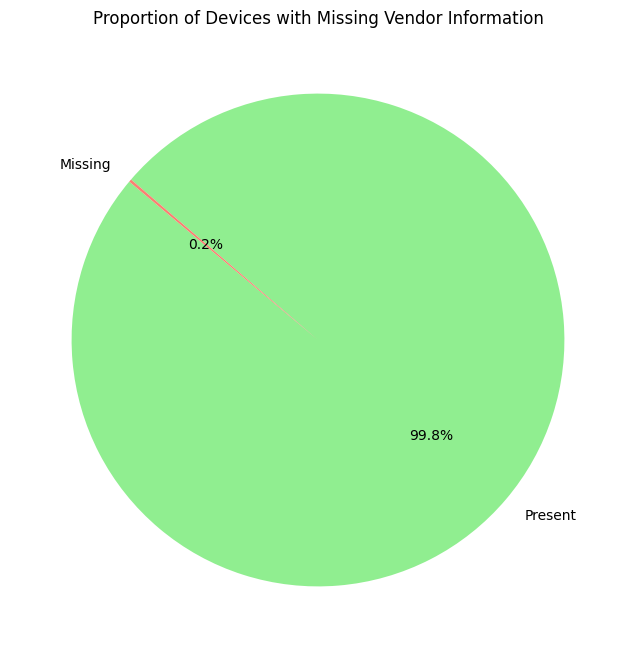

In [13]:
# Pie Chart for Missing Vendor Information
missing_vendor_counts = deviceDF['missing_vendor'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(missing_vendor_counts, labels=['Present', 'Missing'], autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon'])
plt.title('Proportion of Devices with Missing Vendor Information')
plt.show()

### **Insights from the Pie Chart on Missing Vendor Information**  

**Very Few Devices Have Missing Vendor Information**  
   - **Only 0.2% of devices lack vendor details.**  
   - This could be due to:  
     - **Anonymized or spoofed devices** (e.g., bots, VPN users, or modified firmware).  

**Potential Implications**  
   - The **low percentage of missing vendor information** suggests it may not be a critical issue.  
   - However, the small subset of missing vendor data **could still indicate suspicious activity** (e.g., bots, rogue devices).  

In [14]:
deviceDF = deviceDF.fillna("Unknown")

In [15]:
# Group by device_vendor and sum the number of True values in height_mismatch and width_mismatch
mismatch_summary = deviceDF.groupby('device_vendor')[['height_mismatch', 'width_mismatch']].sum()

In [17]:
# Assume deviceDF is already loaded with possible duplicate entries
app = dash.Dash(__name__)

app.layout = html.Div([
    # Dropdown (appears once)
    dcc.Dropdown(
        id='vendor_dropdown',
        options=[{'label': vendor, 'value': vendor} for vendor in deviceDF['device_vendor'].unique()],
        value=deviceDF['device_vendor'].unique()[0],  # Default value
        clearable=False
    ),

    # Bar Chart for Mismatches
    dcc.Graph(id='mismatch_graph'),

    # Graph information
    html.Div(id='graph_info')
])

@app.callback(
    [Output('mismatch_graph', 'figure'),
     Output('graph_info', 'children')],
    [Input('vendor_dropdown', 'value')]
)
def update_graph(vendor):
    # Filter the dataframe based on the selected vendor
    filtered_df = deviceDF[deviceDF['device_vendor'] == vendor]

    # Count the number of True values for height_mismatch and width_mismatch
    mismatch_counts = {
        'Height Mismatch': filtered_df['height_mismatch'].sum(),
        'Width Mismatch': filtered_df['width_mismatch'].sum()
    }

    # Create a bar chart
    mismatch_fig = px.bar(
        x=list(mismatch_counts.keys()),
        y=list(mismatch_counts.values()),
        labels={'x': 'Mismatch Type', 'y': 'Count'},
        title=f'Mismatch Counts for {vendor}'
    )

    # Display the counts and mode values as text
    mode_height = filtered_df['device_height'].mode().iloc[0] if not filtered_df['device_height'].mode().empty else 'N/A'
    mode_width = filtered_df['device_width'].mode().iloc[0] if not filtered_df['device_width'].mode().empty else 'N/A'
    
    graph_info = html.Div([
        html.P(f"Mode of Device Height for {vendor}: {mode_height}"),
        html.P(f"Mode of Device Width for {vendor}: {mode_width}")
    ], style={'backgroundColor': 'white'})

    return mismatch_fig, graph_info

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


### **Insights from the Height and Width Mismatch Data**  
**Trend Observation:**  
   - **More well-known smartphone brands (Samsung, Xiaomi, Oppo, Realme, Vivo) tend to have the highest mismatches.**  
   - This could be due to **a large variety of models**, inconsistencies in reported dimensions, or **regional variations in device manufacturing**.  
   - **Lesser-known brands and some niche manufacturers show no mismatches at all,** possibly due to a smaller dataset size or more consistent device specifications.
   - **Unknown** vendor names are one which are missing, though these devices show **no mismatch in height and width**, they are critical from the point of view of the rarity of their occurrence.